# Importation

Importer les données de Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = "/content/gdrive/My Drive/Gym_trainer/openpose/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Importer les différents modules python

In [2]:
import csv
import numpy as np

from itertools import product
from keras.callbacks import LearningRateScheduler
from keras.initializers import RandomNormal
from keras.layers import  CuDNNLSTM, Dense, Dropout, LSTM
from keras import Input, Model
# from keras.optimizers import Adam
from keras.regularizers import l1, l2
from math import floor, sqrt
from matplotlib import pyplot as plt
from os import listdir
from pickle import load
from random import shuffle

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 18})


Using TensorFlow backend.


# Définition des fonctions

## Données

Changer la forme des matrices

In [0]:
def change_shape(X):
  new_X = []
  for x in X:
    temp = np.concatenate((x[0,:,:], x[1,:,:]), axis=1) # equiv np.concatenate(x[:,:,:], axis=1) ?
    new_X.append(temp)
  return new_X

Enlever les articulations non désirées

In [0]:
def remove_bottom_joints(data):
  joints = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12} # , 15, 16, 17, 18
  new_data = []
  #each video
  for i in range(len(data)):
    shape = data[i].shape
    shape = (shape[0], shape[1], len(joints))
    x = np.zeros(shape)
    # each frame
    for j in range(shape[1]):
      #each joint
      l = 0
      for k in range(25):
        if k in joints:
          x[0, j, l] = data[i][0, j, k]
          l += 1
      #each joint
      l = 0
      for k in range(25):
        if k in joints:
          x[1, j, l] = data[i][1, j, k]
          l += 1

    new_data.append(x)
  return new_data

Supprimer les zéros lorsqu'une articulation n'est pas détectée

In [0]:
def delete_zeros(X):
  """Delete zeros in matrices and replace them with the previous value."""
  for i in range(len(X)):
    matrix = X[i]
    shape = matrix.shape
    for (j,k) in product(range(shape[0]), range(shape[1])):
      if matrix[j, k] == 0:
        matrix[j, k] = matrix[j - 1, k]
  X[i] = matrix
  return X

Trier les matrices par ordre croissant de durée des vidéos

In [0]:
def sort_by_size(x_data, y_data):
  shapes_index = [(i, x_data[i].shape[0]) for i in range(len(x_data))]
  dtype = [('index', int), ('shape', int)]
  shapes_index = np.array(shapes_index, dtype=dtype)
  shapes_index = np.sort(shapes_index, order='shape')
  x_data = [x_data[i] for i,shape in shapes_index]
  y_data = [y_data[i] for i,shape in shapes_index]
  return x_data

Remplir les matrices avec des 0 pour qu'elles aient toutes la même taille

In [0]:
def pad_matrices(matrix_list):
  """Pad matrices with 0."""
  max_length = 0
  new_matrix_list = []
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape[1]
    if shape > max_length:
      max_length = shape
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape
    if shape[0] < max_length: # matrix_list[1].shape[0]
      pad_length = max_length - shape[1]
      pad = np.zeros((2, pad_length, shape[2]))
      new_matrix = np.append(matrix_list[i], pad, axis=1)
    else:
      new_matrix = matrix_list[i]
    new_matrix_list.append(new_matrix)
  new_matrix_list = np.array(new_matrix_list)
  return new_matrix_list

def maximum_size(data, axis):
  max_size = 0
  for x in x_data:
    size = x.shape[axis]
    if size > max_size:
      max_size = size
  return max_size

def new_pad(data, max_size):
  data_pad = []
  last_shape = data[0].shape[1]
  for x in data:
    x_zeros = np.zeros((max_size - x.shape[0], last_shape))
    new_x = np.append(x, x_zeros, axis = 0)
    data_pad.append(new_x)
  return data_pad

Transformer les données

In [0]:
def transform_matrices(X):
  """Transform data."""
  shape = X.shape
  new_X = np.zeros((shape[0], shape[2], shape[1] * shape[3]))
  for i in range(shape[0]):
    for j in range(shape[2]):
      new_X[i, j ,:] = np.reshape(X[i, :, j, :], (1, shape[1] * shape[3]))
  return new_X

Normaliser les données

In [0]:
def standardize(X):
  """Standardize data according to a normal distribution."""
  for i in range(X.shape[2]):
    mu = np.mean(X[:, :, i])
    sigma = np.std(X[:, :, i])
    if sigma != 0:
      X[:, :, i] = (X[:, :, i] - mu) / sigma
  return X

def new_standardize(data):
  """Standardize data."""
  new_data = data
  nb_joints = data[0].shape[1] // 2
  # each video
  for i in range(len(data)):
    # each frame
    for j in range(data[i].shape[0]):
      # middle of hips
      x_center = data[i][j, 8]
      y_center = data[i][j, 8 + nb_joints]
      norm_sq = sqrt(pow(data[i][j, 1], 2) + pow(data[i][j, 1 + nb_joints], 2))
      # each joint
      for k in range(nb_joints):
        if k == 8:
          new_data[i][j, 8] = 0
          new_data[i][j, 8 + nb_joints] = 0
        else:
          if norm_sq != 0:
            new_data[i][j, k] = (data[i][j, k] - x_center) / norm_sq
            new_data[i][j, k + nb_joints] = (data[i][j, k + nb_joints] - y_center) / norm_sq
  return new_data

Mélanger les données

In [0]:
def shuffle_list(*ls):
  l = list(zip(*ls))
  shuffle(l)
  return l

def deshuffle(ls):
  x = []
  y = []
  for (i,j) in ls:
    x.append(i)
    y.append(j)
  return x, y

Découper les données entre ensemble de test et ensemble d'apprentissage

In [0]:
def split_data(X, y, index):
  """Split data betwenn train set and test set."""
  X_test = np.array(X[index + 1:])
  y_test = np.array(y[index + 1:])
  X_train = np.array(X[0:index])
  y_train = np.array(y[0:index])
  return (X_test , y_test, X_train, y_train)

## Modèle

Définir le modèle du LSTM

In [0]:
def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * pow(drop, floor((1 + epoch)/epochs_drop))
  return lrate
  
def define_model(input_size, first_size, second_size):
  inputs = Input(shape=input_size, name='input')
  lstm_layer = LSTM(first_size, 
                         kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                         kernel_regularizer=l2(0.05),
                         activity_regularizer=l1(0.01))(inputs)
  hidden_layer = Dense(second_size, activation='relu',
                       kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                       kernel_regularizer=l2(0.05),
                       activity_regularizer=l1(0.01))(lstm_layer)
  hidden_layer = Dropout(rate=0.2)(hidden_layer)
  outputs = Dense(1, activation='linear',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                  kernel_regularizer=l2(0.05),
                  activity_regularizer=l1(0.01))(hidden_layer)
  model = Model(inputs, outputs)
  model.summary()
  model.compile(loss='mean_squared_error', metrics=['mse'], optimizer="adam")
  return model

Afficher l'historique du modèle

In [0]:
def print_history(history, name="default"):
  """Summarize history by printing the loss of the model."""
  fig, ax = plt.subplots(figsize=(10,10))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set(title='model loss', ylabel='loss', xlabel='epoch')
  ax.legend(['train', 'test'], loc='upper left')
  ax.grid(True, linestyle='-.')
  plt.show()
  fig.savefig(name + '.eps', format='eps', dpi=1200)


Afficher les résultats du modèle

In [0]:
def print_results(model, X, y, name="default"):
  """Print the results of the model."""
  predict_y = model.predict(X)
  RMSE_test = np.linalg.norm(predict_y - y) / len(y)
  print("RMSE", name, RMSE_test)
  predict_y = predict_y.flatten()
  corr = np.corrcoef(y, predict_y)
  print("corr", name, corr[0,1])
  fig, ax = plt.subplots(figsize=(10,10))
  ax.scatter(y, predict_y)
  ax.set(title='Predicted/real values', xlabel='real mark',
         ylabel='predicted mark')
  ax.grid(True, linestyle='-.')
  plt.show()
  fig.savefig(name + '.eps', format='eps', dpi=1200)
  return corr[0,1]

Créer plein de modèles

In [0]:
PATH_MODEL = PATH + "lstm_config"

def for_model(input_size, low_bound, high_bound, low_bound2, high_bound2):
  # layer = list(map(lambda x: int(input_size[0]*input_size[1]//(10*x)), range(low_bound, high_bound)))
  layer = list(map(lambda x: int(pow(2,x)), range(low_bound, high_bound)))
  layer2 = list(map(lambda x: int(pow(2,x)), range(low_bound2, high_bound2)))
  corr_matrix = []
  for (i,j) in product(layer, layer2):
    model = define_model(input_size, i, j)
    lrate = LearningRateScheduler(step_decay)
    history = model.fit(x=X_train, y=y_train, epochs=80,
                        validation_data=(X_test, y_test), callbacks=[lrate],
                        shuffle=True, verbose=0)
    print_history(history, PATH + "lstm_history" + "_" + str(i) + "_" + str(j))
    corr = print_results(model, X_test, y_test, PATH + "lstm_results" + "_" + str(i) + "_" + str(j))
    #print_results(model, X_train, y_train, "train")
    y_prediction = (np.array(model.predict(X_test))).flatten()
    print("Dimensions : ", i, "et", j, ", correlation :", corr)
    corr_matrix.append((i, j, corr))
    model.save(PATH_MODEL + "_" + str(i) + "_" + str(j) + '.h5')
  return corr_matrix


# Programme

Charger les données

In [0]:
PATH_NPY = "/content/gdrive/My Drive/Gym_trainer/openpose/output/"
PATH_CSV = "/content/gdrive/My Drive/Gym_trainer/openpose/csv/"

# Sans les squats
npy_files = listdir(PATH_NPY)
npy_files.sort()
x_data = []
for f in npy_files:
  # x_data.append(np.load(PATH_NPY + f))
  path = PATH_CSV + f[0:3] + '.csv'
  #remove squat
  with open(path) as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
      if len(row) == 5:
        if row[0][0:6] == f[0:-4] and int(row[1]) == 8:
          indx = int(row[3])
          break
  temp = np.load(PATH_NPY + f) 
  x_data.append(temp[: , 0:indx, :])

# X_raw = load(open(PATH + "Matrices.p", "rb"))
# Personnes = np.load(PATH + 'Personnes.npy')
y_data = np.load(PATH + 'Notes.npy')

Traiter les données

In [0]:
X = list(x_data)
y = np.copy(y_data)
X = remove_bottom_joints(X)
X = change_shape(X)
X = delete_zeros(X)
X = sort_by_size(X, y)
X = X[-84:]
y = y[-84:]
max_size = maximum_size(X, 1)
X = new_pad(X, max_size)
# X = transform_matrices(X)
X = new_standardize(X)
#y /= 45 
# temp = shuffle_list(X, y)
# X, y = deshuffle(temp)

Séparer les données

In [0]:
indice = int(len(X)*0.80)
X_test , y_test, X_train, y_train = split_data(X, y, indice)

Créer le modèle

In [0]:
input_size = X[0].shape
# optimizer = Adam(lr=.001)
lrate = LearningRateScheduler(step_decay)
nb_epochs = 50
model = define_model(input_size, 2048, 128)
history = model.fit(X_train, y_train, epochs=nb_epochs, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[lrate],
                    shuffle=True)

Récupérer les résultats du modèle

In [0]:
print_history(history, PATH + "lstm_history")
print_results(model, X_test, y_test, PATH + "lstm_results_test")
print_results(model, X_train, y_train, PATH + "lstm_results_train")

Sauvegarder le modèle

In [0]:
model.save(PATH + "lstm_config.h5")

Créer beaucoup de modèles

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1024)              4288512   
_________________________________________________________________
dense_21 (Dense)             (None, 32)                32800     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 4,321,345
Trainable params: 4,321,345
Non-trainable params: 0
_________________________________________________________________


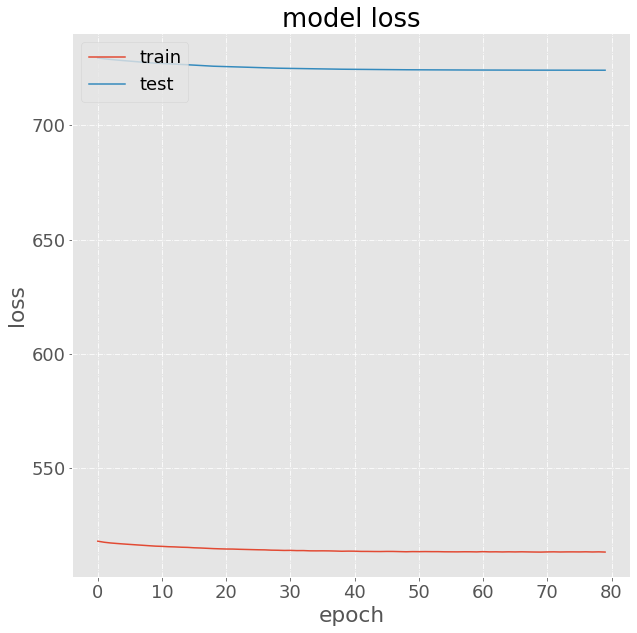

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_32 26.909058661524856
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_32 0.05330398122591969


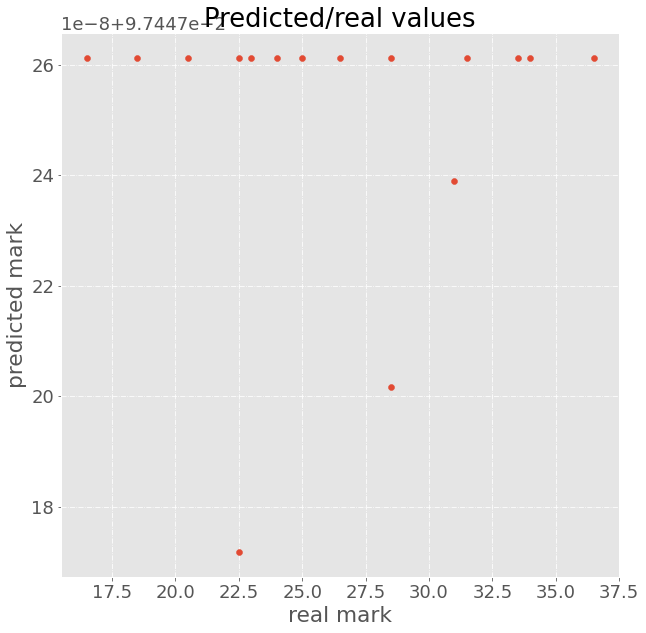

Dimensions :  1024 et 32 , correlation : 0.05330398122591969
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1024)              4288512   
_________________________________________________________________
dense_23 (Dense)             (None, 64)                65600     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 4,354,177
Trainable params: 4,354,177
Non-trainable params: 0
_________________________________________________________________


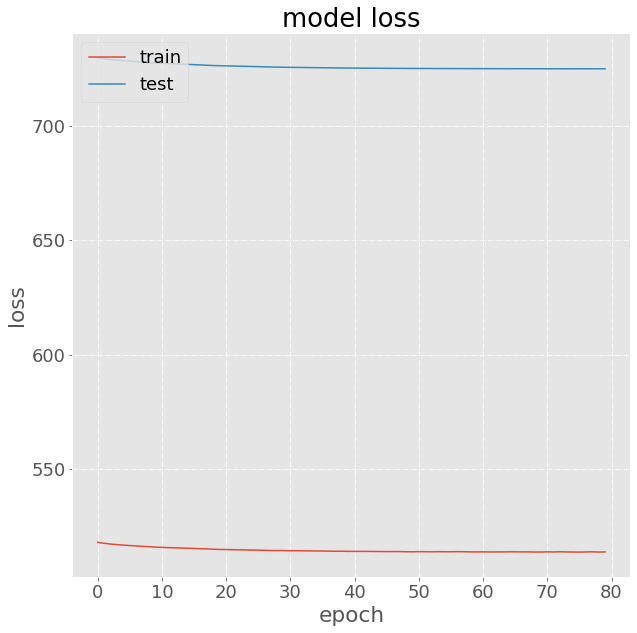

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_64 26.92502962301252
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_64 -0.23462088028371275


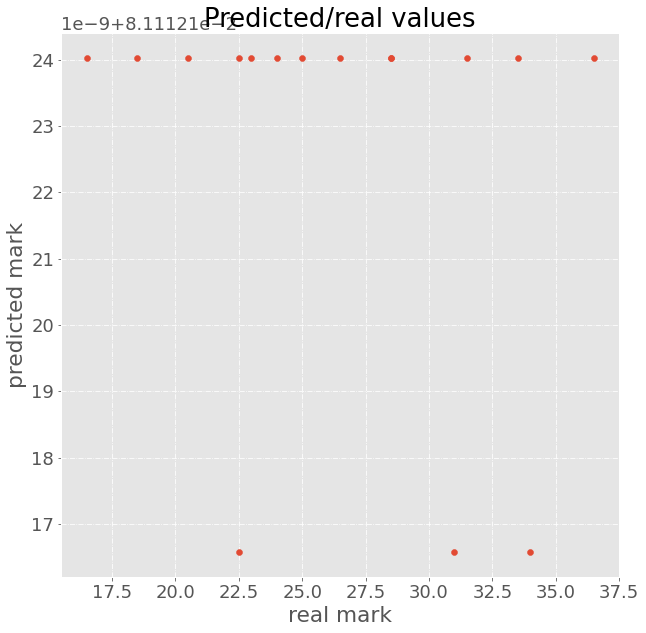

Dimensions :  1024 et 64 , correlation : -0.23462088028371275
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1024)              4288512   
_________________________________________________________________
dense_25 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 4,419,841
Trainable params: 4,419,841
Non-trainable params: 0
_________________________________________________________________


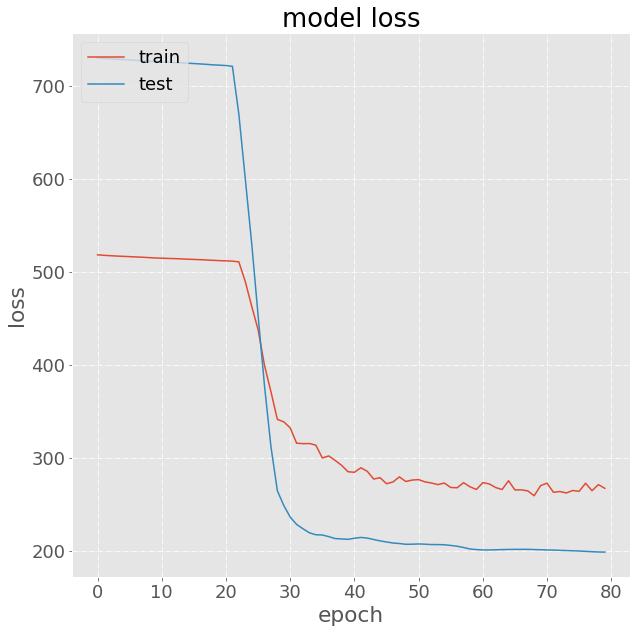

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_128 9.992264097533681
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_128 -0.08147370811265534


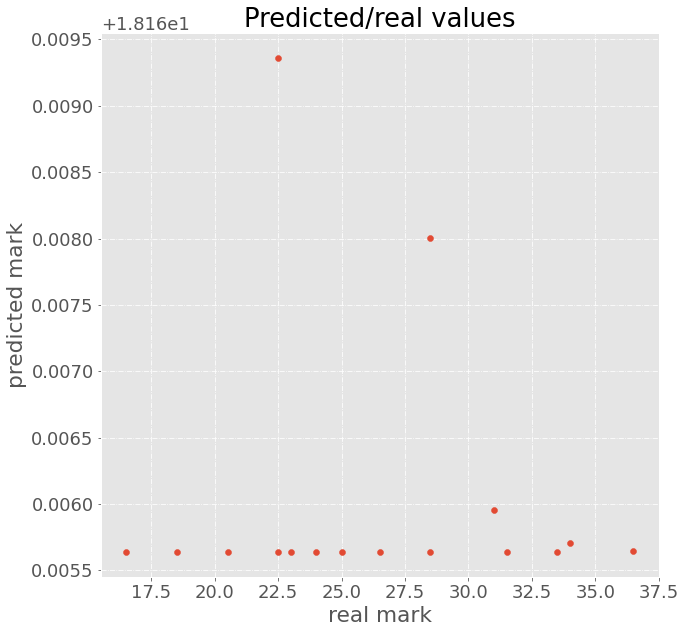

Dimensions :  1024 et 128 , correlation : -0.08147370811265534
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1024)              4288512   
_________________________________________________________________
dense_27 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 4,551,169
Trainable params: 4,551,169
Non-trainable params: 0
_________________________________________________________________


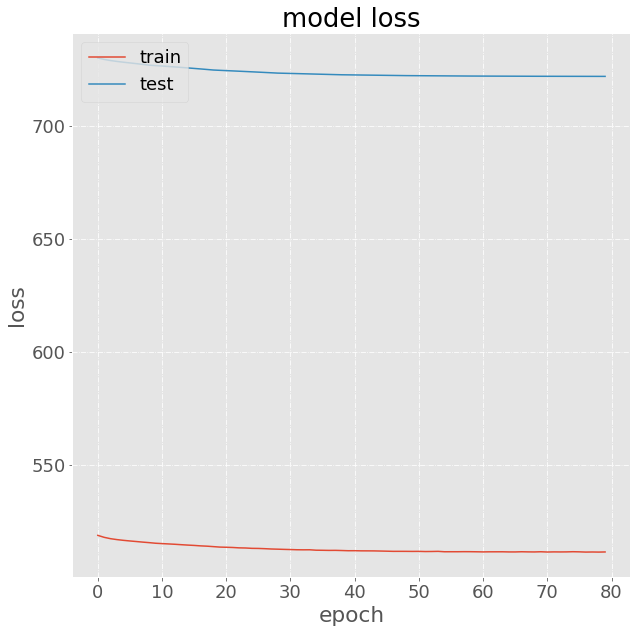

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_256 26.86861352741585
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_256 0.05479855082558607


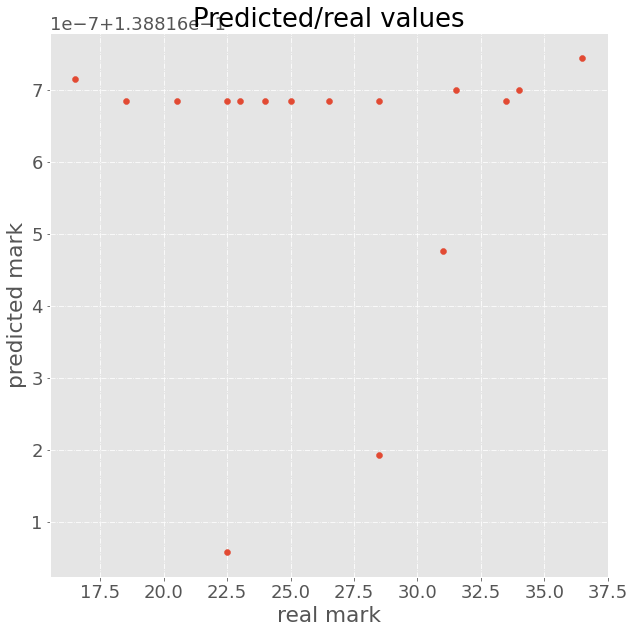

Dimensions :  1024 et 256 , correlation : 0.05479855082558607
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1024)              4288512   
_________________________________________________________________
dense_29 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 4,813,825
Trainable params: 4,813,825
Non-trainable params: 0
_________________________________________________________________


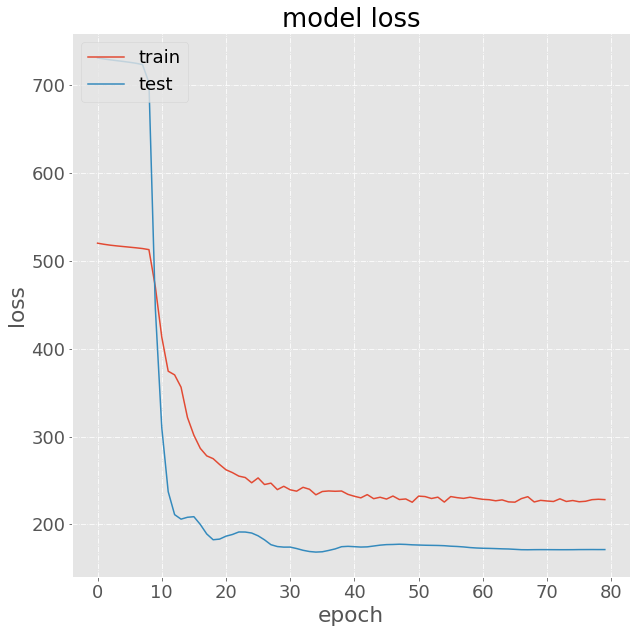

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_512 9.46305896167522
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_1024_512 -0.15038994202004075


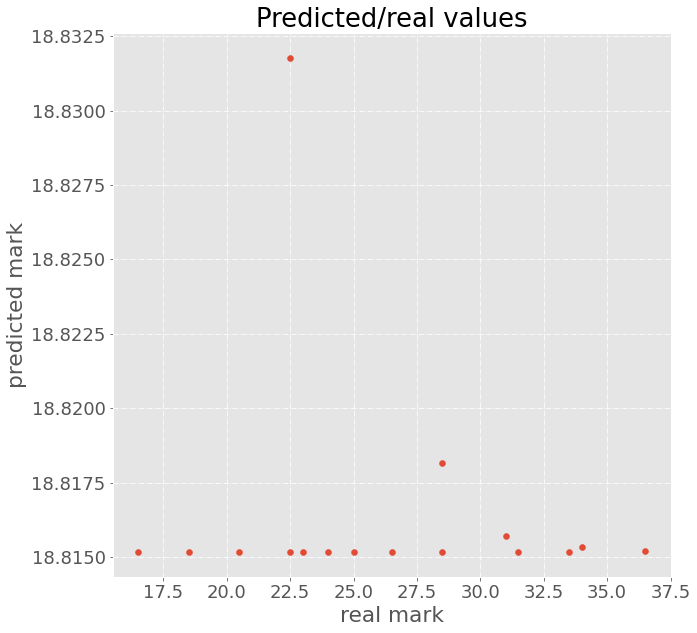

Dimensions :  1024 et 512 , correlation : -0.15038994202004075
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 2048)              16965632  
_________________________________________________________________
dense_31 (Dense)             (None, 32)                65568     
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 17,031,233
Trainable params: 17,031,233
Non-trainable params: 0
_________________________________________________________________


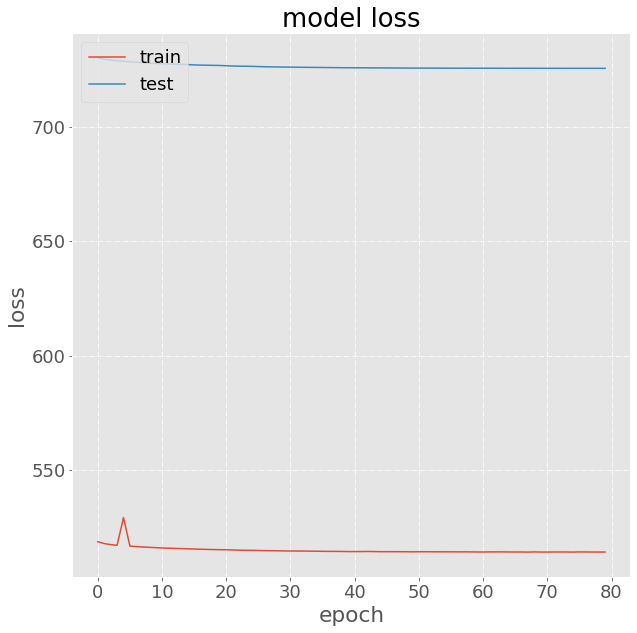

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_2048_32 26.935449099905753
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_2048_32 0.0008163617168193622


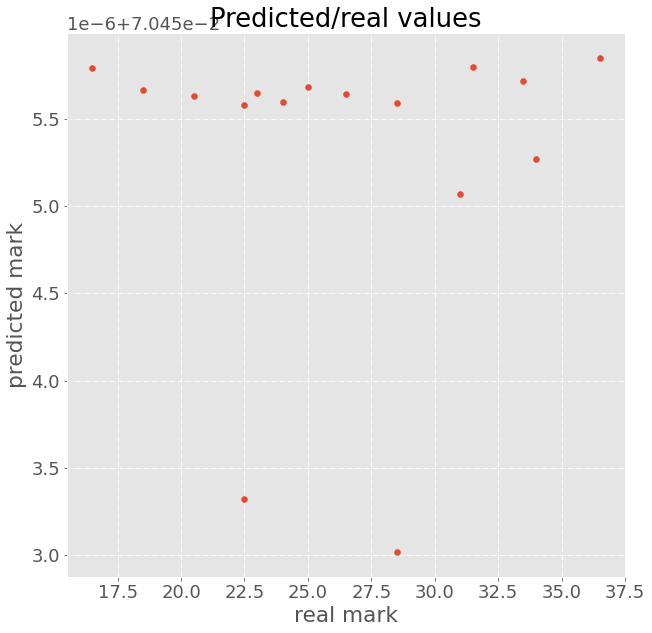

Dimensions :  2048 et 32 , correlation : 0.0008163617168193622
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 2048)              16965632  
_________________________________________________________________
dense_33 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 17,096,833
Trainable params: 17,096,833
Non-trainable params: 0
_________________________________________________________________


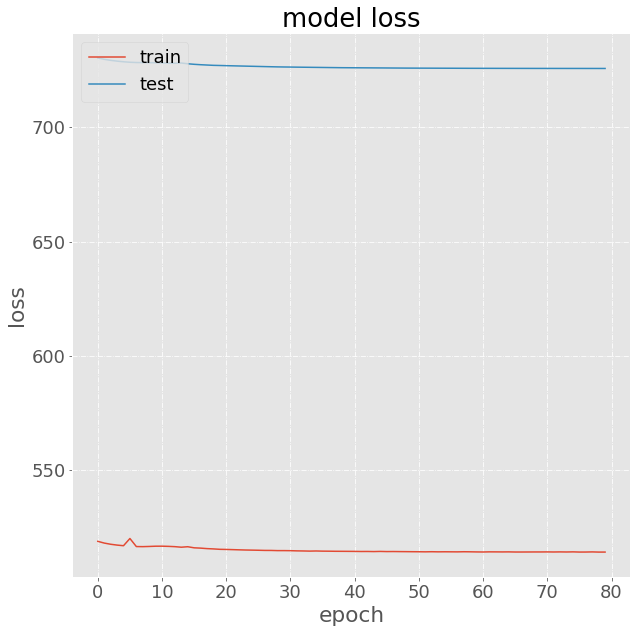

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_2048_64 26.927416456368036
corr /content/gdrive/My Drive/Gym_trainer/openpose/lstm_results_2048_64 -0.09775847812510519


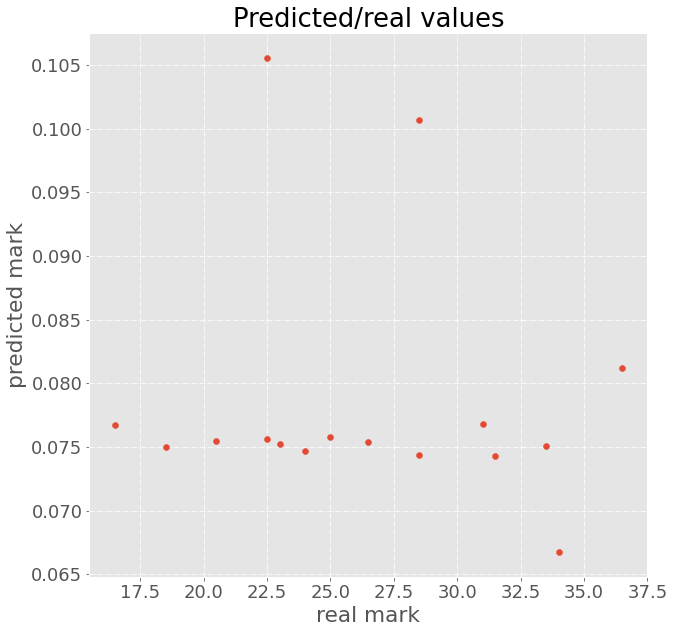

Dimensions :  2048 et 64 , correlation : -0.09775847812510519
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 313, 22)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 2048)              16965632  
_________________________________________________________________
dense_35 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 129       
Total params: 17,228,033
Trainable params: 17,228,033
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: ignored

In [28]:
input_size = X[0].shape
correlation_list = for_model(input_size, 10,13, 5, 10)
print(correlation_list)